<a href="https://colab.research.google.com/github/xygxue/master_thesis/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [2]:
my_drive_path = '/content/gdrive/MyDrive/'
dataset_path = my_drive_path + 'FSFM/master_thesis/data/'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

from datetime import timedelta
import plotly.graph_objects as go

In [4]:
raw_trans = pd.read_csv(dataset_path+'clean/clean_trans.csv', sep=',')
raw_client = pd.read_csv(dataset_path+'clean/client_info.csv', sep=',')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


***Helper Functions***

In [47]:
def normalize(df):
  # use z-score to normalize the columns in dataframe 
  df_norm = (df - df.mean(axis=0))/df.std(axis=0)
  return df_norm

def encode_cyclicals(df):
    # "month","day","hour", "dayofweek"
    
    df['month_sin'] = np.sin(2*np.pi*df.month/12)
    df['month_cos'] = np.cos(2*np.pi*df.month/12)
    df.drop('month', axis=1, inplace=True)

    df['month_sin'] = np.sin(2*np.pi*df.month/12)
    df['month_cos'] = np.cos(2*np.pi*df.month/12)
    df.drop('month', axis=1, inplace=True)
    
    df['day_sin'] = np.sin(2*np.pi*df.day/31)
    df['day_cos'] = np.cos(2*np.pi*df.day/31)
    df.drop('day', axis=1, inplace=True)

    df['dayofweek_sin'] = np.sin(2*np.pi*df.dayofweek/7)
    df['dayofweek_cos'] = np.cos(2*np.pi*df.dayofweek/7)
    df.drop('dayofweek', axis=1, inplace=True)
    
    return df

def kmeans(X, cluster_number):
  kmeans = KMeans(n_clusters = cluster_number)
  kmeans.fit(X)
  labels = kmeans.labels_
  return labels

def cluster_score(X, labels):
  unique, counts = np.unique(labels, return_counts=True)
  cluster_count = dict(zip(unique, counts))

  silhouette = round(silhouette_score(X, labels),3)
  davies_bouldin = round(davies_bouldin_score(X, labels),3)

  return silhouette, davies_bouldin

def scatter_plot(X, labels, model_name):
  scatter = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers', 
                       marker=dict(color=labels, line_width=0.1),
                       name=model_name)
  fig = go.Figure(data=[scatter])
  fig.show()

def plot_cluster_tuning(sil_list, db_index_list):
  plt.figure(figsize=(10,8))
  x_axis = list(range(2, 10))
  plt.plot(x_axis, sil_list, label=f'SC')
  plt.plot(x_axis, db_index_list, label=f'DBI')
  plt.xlabel("Cluster Number")
  plt.ylabel("Score")
  plt.legend()
  print("Silhouette: The best value --> 1 and the worst value --> -1.")
  print("Davies–Bouldin index: lower values --> better clustering.")

### *Client table*

In [ ]:
raw_client.head()

,account_id,frequency,disp_id,client_id,type,district_id,gender,age,district_name,region_name,...,city_number,urban_inhabitants_ratio,average salary,1995_unemployment_rate,1996_unemployment_rate,entrepreneurs_per_1000_inhabitants,crimes_committed_number_in_1995,crimes_committed_number_in_1996,lat,lon
0,A0000000576,Monthly Issuance,D0000000692,C0000000692,OWNER,74,0.0,62,Ostrava - mesto,north Moravia,...,1,100.0,10673,4.75,5.44,100,18782.0,18347,49.834650,18.282040
1,A0000000576,Monthly Issuance,D0000000693,C0000000693,DISPONENT,74,1.0,63,Ostrava - mesto,north Moravia,...,1,100.0,10673,4.75,5.44,100,18782.0,18347,49.834650,18.282040
2,A0000003818,Monthly Issuance,D0000004601,C0000004601,OWNER,1,1.0,63,Hl.m. Praha,Prague,...,1,100.0,12541,0.29,0.43,167,85677.0,99107,50.006143,14.336773
3,A0000003818,Monthly Issuance,D0000004602,C0000004602,DISPONENT,1,0.0,64,Hl.m. Praha,Prague,...,1,100.0,12541,0.29,0.43,167,85677.0,99107,50.006143,14.336773
4,A0000000704,Monthly Issuance,D0000000844,C0000000844,OWNER,22,1.0,53,Domazlice,west Bohemia,...,6,52.4,8620,1.10,1.25,100,1089.0,1117,49.500000,12.916670


In [ ]:
raw_client_copy = raw_client.copy()
client_no_disp = raw_client_copy[raw_client_copy['type'] == 'OWNER']
client_clean = client_no_disp.drop(columns=[
                      'disp_id_x','disp_id_y', 'client_id', 'account_id_y',  
                      'district_id', 'frequency', 'type', 'district_name',
                      'region_name', '1995_unemployment_rate', 
                      'crimes_committed_number_in_1995',
                      'number_of_municipalities_with_<499_inhabitants',
                      'number_of_municipalities_with_500-1499_inhabitants',
                      'number_of_municipalities_with_2000-9999_inhabitants',
                      'number_of_municipalities_with_>10000_inhabitants'])
client_clean.set_index('account_id_x', inplace=True)
client_clean.head()

,gender,age,inhabitants_number,city_number,urban_inhabitants_ratio,average salary,1996_unemployment_rate,entrepreneurs_per_1000_inhabitants,crimes_committed_number_in_1996,lat,lon
account_id_x,,,,,,,,,,,
A0000000576,0.0,62,323870,1,100.0,10673,5.44,100,18347,49.834650,18.282040
A0000003818,1.0,63,1204953,1,100.0,12541,0.43,167,99107,50.006143,14.336773
A0000000704,1.0,53,58400,6,52.4,8620,1.25,100,1117,49.500000,12.916670
A0000002378,0.0,23,93931,8,56.9,8427,1.54,107,1913,49.144040,15.003010
A0000002632,1.0,60,122603,8,80.0,8991,2.01,128,5273,50.232710,12.871170


In [ ]:
client_clean.isnull().sum()

gender                                0
age                                   0
inhabitants_number                    0
city_number                           0
urban_inhabitants_ratio               0
average salary                        0
1996_unemployment_rate                0
entrepreneurs_per_1000_inhabitants    0
crimes_committed_number_in_1996       0
lat                                   0
lon                                   0
dtype: int64

In [ ]:
client_norm = normalize(client_clean)
client_norm

,gender,age,inhabitants_number,city_number,urban_inhabitants_ratio,average salary,1996_unemployment_rate,entrepreneurs_per_1000_inhabitants,crimes_committed_number_in_1996,lat,lon
account_id_x,,,,,,,,,,,
A0000000576,-1.018731,1.046780,0.158534,-1.546618,1.552939,0.879002,0.910185,-0.916339,0.069923,0.039679,1.538008
A0000003818,0.981395,1.105308,2.628601,-1.546618,1.552939,2.289783,-1.439375,1.991495,2.665064,0.312926,-0.544652
A0000000704,0.981395,0.520028,-0.585696,0.160801,-0.848241,-0.671499,-1.054817,-0.916339,-0.483746,-0.493535,-1.294307
A0000002378,-1.018731,-1.235813,-0.486087,0.843769,-0.621239,-0.817260,-0.918814,-0.612535,-0.458167,-1.060703,-0.192953
A0000002632,0.981395,0.929724,-0.405706,0.843769,0.544040,-0.391306,-0.698396,0.298875,-0.350197,0.673926,-1.318326
...,...,...,...,...,...,...,...,...,...,...,...
A0000000124,0.981395,0.344444,-0.309158,1.185253,-1.781473,-0.578605,-0.501427,-0.438933,-0.394510,-1.024645,0.597290
A0000003958,0.981395,0.168860,-0.444203,0.160801,-0.358925,-0.804421,-0.013694,-0.655936,-0.445571,-0.815630,1.068758
A0000000777,0.981395,1.105308,-0.483617,1.526736,0.634841,0.106395,0.080101,-0.916339,-0.429536,0.592012,-1.440305


### *Transaction Table*

In [6]:
raw_trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,T0000695247,A0000002378,1993-01-01,credit,deposit,700.0,700.0,NaN,NaN,NaN
1,T0000171812,A0000000576,1993-01-01,credit,deposit,900.0,900.0,NaN,NaN,NaN
2,T0000207264,A0000000704,1993-01-01,credit,deposit,1000.0,1000.0,NaN,NaN,NaN
3,T0001117247,A0000003818,1993-01-01,credit,deposit,600.0,600.0,NaN,NaN,NaN
4,T0000579373,A0000001972,1993-01-02,credit,deposit,400.0,400.0,NaN,NaN,NaN


In [7]:
raw_trans.operation.unique()

array(['deposit', 'collection_from_another_bank', 'withdraw_cash',
       'interest_pmt', 'transer_to_another_bank',
       'credit_card_withdrawal'], dtype=object)

In [8]:
raw_trans.k_symbol.unique()

array([nan, 'pension', 'interest_pmt', 'household', 'service',
       'insurrance_pmt', 'interest_for_negetive_balance', 'loan_pmt'],
      dtype=object)

One Hot Encoding Categorical Features

In [9]:
one_hot_trans = pd.get_dummies(raw_trans[['operation']])

Cyclicals Encoding

In [10]:
date_col = pd.DatetimeIndex(raw_trans['date'])
raw_trans['date'] = date_col
benchmark_date = date_col.max() + timedelta(days=1)
print(benchmark_date)

1999-01-01 00:00:00


In [11]:
raw_trans['year'] = date_col.year
raw_trans['month'] = date_col.month
raw_trans['day'] = date_col.day
raw_trans['dayofweek'] = date_col.dayofweek

In [12]:
trans_to_merge = raw_trans[['trans_id', 'account_id', 'amount', 'balance', 
                            'year', 'month', 'day', 'dayofweek']]
trans = trans_to_merge.join(one_hot_trans)
trans.set_index('trans_id', inplace=True)
trans_norm = normalize(trans.drop(columns=['account_id'], inplace=False))
trans_norm['account_id'] = trans['account_id']
trans_norm

,amount,balance,year,month,day,dayofweek,operation_collection_from_another_bank,operation_credit_card_withdrawal,operation_deposit,operation_interest_pmt,operation_transer_to_another_bank,operation_withdraw_cash,account_id
trans_id,,,,,,,,,,,,,
T0000695247,-0.548597,-1.709854,-2.504467,-1.555385,-1.701858,0.494807,-0.256539,-0.087555,2.395658,-0.457933,-0.495586,-0.836599,A0000002378
T0000171812,-0.527595,-1.700812,-2.504467,-1.555385,-1.701858,0.494807,-0.256539,-0.087555,2.395658,-0.457933,-0.495586,-0.836599,A0000000576
T0000207264,-0.517094,-1.696291,-2.504467,-1.555385,-1.701858,0.494807,-0.256539,-0.087555,2.395658,-0.457933,-0.495586,-0.836599,A0000000704
T0001117247,-0.559098,-1.714375,-2.504467,-1.555385,-1.701858,0.494807,-0.256539,-0.087555,2.395658,-0.457933,-0.495586,-0.836599,A0000003818
T0000579373,-0.580101,-1.723418,-2.504467,-1.555385,-1.603791,0.993325,-0.256539,-0.087555,2.395658,-0.457933,-0.495586,-0.836599,A0000001972
...,...,...,...,...,...,...,...,...,...,...,...,...,...
T0003626622,-0.615563,-1.120765,1.073430,1.514539,1.240166,-0.003711,-0.256539,-0.087555,-0.417421,2.183722,-0.495586,-0.836599,A0000002906
T0003627616,-0.613568,-0.857833,1.073430,1.514539,1.240166,-0.003711,-0.256539,-0.087555,-0.417421,2.183722,-0.495586,-0.836599,A0000002935
T0003625403,-0.615784,-1.079676,1.073430,1.514539,1.240166,-0.003711,-0.256539,-0.087555,-0.417421,2.183722,-0.495586,-0.836599,A0000002869


In [13]:
trans_acc_grp_unnorm = trans.groupby(['account_id'])
trans_acc_grp_unnorm.size()

account_id
A0000000001    239
A0000000002    478
A0000000003    117
A0000000004    186
A0000000005     84
              ... 
A0000011333    368
A0000011349    304
A0000011359    378
A0000011362    344
A0000011382    253
Length: 4500, dtype: int64

In [14]:
trans_acc_grp = trans_norm.groupby(['account_id'])
max_trans_len = trans_acc_grp.size().max()
max_trans_len

675

In [15]:
sequence_input_list = []
sequence_output_list = []
non_sos_eos_list = []
no_padding_list = []
reduced_feat_list = []
for k, v in trans_acc_grp:
    user_trans_array = v.drop(columns=['account_id']).values
    reduced_trans_array = v.drop(columns=['account_id', 'balance', 
                                        'operation_credit_card_withdrawal', 
                                        'operation_deposit',
                                        'operation_interest_pmt', 
                                        'operation_transer_to_another_bank',
                                        'operation_withdraw_cash',
                                        'operation_collection_from_another_bank']).values
    array = user_trans_array.copy()
    array_no_sos_eos = user_trans_array.copy()
    # add start and end to sequence of transations
    add_start_to_array = np.insert(array, 0, [-1]*12, axis=0)
    input_array = np.append(add_start_to_array, [[-2]*12], axis=0)
    output_array = np.append(array, [[-2]*12], axis=0)
    # resize array to max_lenght
    input_array.resize((max_trans_len, 12), refcheck=False)
    output_array.resize((max_trans_len, 12), refcheck=False)
    array_no_sos_eos.resize((max_trans_len, 12), refcheck=False)
    # append them to list
    sequence_input_list.append(input_array)
    sequence_output_list.append(output_array)
    non_sos_eos_list.append(array_no_sos_eos)
    no_padding_list.append(array)
    reduced_feat_list.append(reduced_trans_array)

In [16]:
sequence_input_array = np.array(sequence_input_list)
sequence_output_input_array = sequence_input_array
sequence_output_array = np.array(sequence_output_list)
non_sos_eos_array = np.array(non_sos_eos_list)
no_padding_array = np.array(no_padding_list)
reduced_feat_array = np.array(reduced_feat_list)
sequence_output_array.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(4500, 675, 12)

## **Modeling**

### **LSTM Extract Latent Space**

In [17]:
import tensorflow as tf
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.advanced_activations import PReLU, LeakyReLU

from tensorflow import feature_column, keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from keras.layers import Dense, LSTM, GRU, dot, Input, Embedding, \
 TimeDistributed, Dropout, Bidirectional, Concatenate, GlobalMaxPooling1D

In [206]:
def create_model():
  latent_dim = 36
  decoder_dim = 12
  num_dynamic_features = 12
  dropout_rate = 0.2
  ###########################################  encoder  ###########################################

  # Sequence input shape is N*2 which N is sequence length and 2 is price and time
  sequence_input = Input(name='sequence_input', shape=(None, num_dynamic_features))

  # Many_to_one_lstm
  outputs  = LSTM(128, return_sequences=True)(sequence_input)

  encoder_out , hidden_state, cell_state = LSTM(latent_dim, return_state=True, return_sequences=True)(outputs)

  latent_space = Concatenate()([hidden_state, cell_state])
  #Layer below output can be used for clustering purposes
  latent_space = Dense(latent_dim, activation = 'relu', name='latent_space')(latent_space)

  ###########################################  /encoder  ###########################################

  ###########################################  decoder  ###########################################

  # Temporary input with a time step delay for producing sequence output
  # This input is exacly similar to sequence_input with only this diffrence that has a time step delay
  sequence_output_input = Input(name='sequence_output_input', shape=(None, num_dynamic_features))

  # One to many GRU (because of its simplicity, we used GRU instead of LSTM)
  decoder_out = GRU(latent_dim, return_sequences=True)(sequence_output_input, initial_state = latent_space)
  ###########################################  attention  ###########################################
  attention = dot([decoder_out, encoder_out], axes=[2, 2])
  attention = Activation('softmax')(attention)
  context = dot([attention, encoder_out], axes=[2,1])
  decoder_combined_context = Concatenate()([context, decoder_out])
  ###########################################  /attention  ###########################################

  decoder_outputs = TimeDistributed(Dense(decoder_dim, activation='sigmoid'),name='decoder_outputs')(decoder_combined_context)

  ###########################################  /decoder  ###########################################

  # Model has three inputs and 2 outputs (last input is temorary)
  model = Model(inputs = [sequence_input, sequence_output_input],
              outputs = [decoder_outputs])

  return model

In [207]:

lr = 0.01
adam = Adam(lr)
with tf.device("/gpu:0"):
    model = create_model()
    model.compile(optimizer=adam, loss=MSE)
    model.summary()

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, None, 12)]   0           []                               
                                                                                                  
 lstm_32 (LSTM)                 (None, None, 128)    72192       ['sequence_input[0][0]']         
                                                                                                  
 lstm_33 (LSTM)                 [(None, None, 36),   23760       ['lstm_32[0][0]']                
                                 (None, 36),                                                      
                                 (None, 36)]                                                      
                                                                                           

In [208]:
batch_size = 512
inputs = [sequence_input_array, sequence_output_input_array]
outputs = [sequence_output_array]

training_history = model.fit(inputs, outputs,
                             epochs=80,
                             batch_size = batch_size,
                             validation_split=0.1)

Epoch 1/80
8/8 [==============================] - 10s 450ms/step - loss: 0.4285 - val_loss: 0.4441
Epoch 2/80
8/8 [==============================] - 2s 312ms/step - loss: 0.3311 - val_loss: 0.4173
Epoch 3/80
8/8 [==============================] - 2s 314ms/step - loss: 0.3183 - val_loss: 0.4012
Epoch 4/80
8/8 [==============================] - 2s 313ms/step - loss: 0.3109 - val_loss: 0.3953
Epoch 5/80
8/8 [==============================] - 2s 314ms/step - loss: 0.3063 - val_loss: 0.3909
Epoch 6/80
8/8 [==============================] - 2s 312ms/step - loss: 0.3007 - val_loss: 0.3851
Epoch 7/80
8/8 [==============================] - 2s 313ms/step - loss: 0.2941 - val_loss: 0.6237
Epoch 8/80
8/8 [==============================] - 2s 314ms/step - loss: 0.3190 - val_loss: 0.3791
Epoch 9/80
8/8 [==============================] - 2s 314ms/step - loss: 0.2861 - val_loss: 0.3767
Epoch 10/80
8/8 [==============================] - 3s 318ms/step - loss: 0.2822 - val_loss: 0.3748
Epoch 11/80
8/8 [=

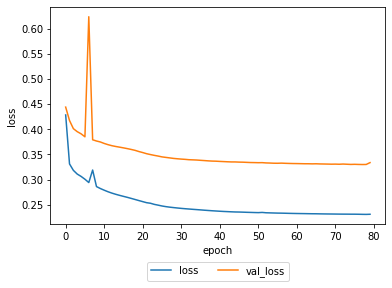

In [209]:
train_mae = training_history.history['loss']
valid_mae = training_history.history['val_loss']
plt.plot(train_mae, label='loss'), 
plt.plot(valid_mae, label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [210]:
encoder = Model(model.input, model.get_layer("latent_space").output)
lstm_predictions = encoder.predict(inputs, batch_size=batch_size, verbose=1)
np.save(dataset_path + "lstm_predictions.npy", lstm_predictions)  

9/9 [==============================] - 1s 65ms/step


#### Evaluation

In [201]:
import plotly.graph_objects as go
from matplotlib.pyplot import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [202]:
max_cluster = 10

In [203]:
def cluster_number_tuning(prediction, max_cluster): 
  sc = StandardScaler()
  encode_pred_norm = sc.fit_transform(prediction)
  pca = PCA(n_components=3)
  encoder_pred = pca.fit_transform(encode_pred_norm)
  sil_list = []
  db_index_list = []
  for cluster_num in range(2, max_cluster):
    labels = kmeans(encode_pred_norm, cluster_num)
    sil, db = cluster_score(encode_pred_norm, labels)
    sil_list.append(sil)
    db_index_list.append(db)

  print(sil_list)
  print(db_index_list)
  return sil_list, db_index_list, encoder_pred

In [204]:
sil_list, db_index_list, encoder_pred_lstm = cluster_number_tuning(lstm_predictions, max_cluster)

[0.841, 0.784, 0.55, 0.55, 0.44, 0.412, 0.416, 0.409]
[0.21, 0.456, 0.657, 0.655, 0.766, 0.775, 0.763, 0.764]


In [205]:
lstm_labels = kmeans(encoder_pred_lstm, 3)
scatter_plot(encoder_pred_lstm, lstm_labels, "LSTM Encoder")

A Transformer-Based Framework For Multivariate Time Series Representation Learning

In [ ]:
import torch

In [ ]:
transformer_pred = torch.load(dataset_path + 'clustering/latent_space_output.pt', map_location=torch.device('cpu'))

In [ ]:
transformer_pred_array = transformer_pred.detach().numpy()
transformer_pred_array_2d = np.reshape(transformer_pred_array, (transformer_pred_array.shape[0],-1))
transformer_pred_array_2d.shape

In [ ]:
sil_transf, db_index_transf, encoder_pred_transf = cluster_number_tuning(transformer_pred_array_2d, max_cluster)
plot_cluster_tuning(sil_transf, db_index_transf)

In [ ]:
encoder_label_transf = kmeans(encoder_pred_transf, 2)

fig = go.Figure(data=[scatter_plot(transformer_pred_array_2d, encoder_label_transf, "Transformer Encoder")])
fig.show()

### **Dynamic Time Warping (DTW)**

In [185]:
from multiprocessing import Pool, cpu_count
from sklearn.cluster import DBSCAN
from dtaidistance import dtw_ndim, clustering
from tqdm import tqdm
import numpy as np
import os

In [ ]:
def dynamic_time_warping_matrix(reduced_feat_array, relative_cpu_cores=0.8):
    number_of_elements = len(reduced_feat_array)
    distance_2d = [[0.0] * number_of_elements for _ in range(number_of_elements)]

    print("CPUs available:", cpu_count())
    cpus = int(cpu_count() * relative_cpu_cores)
    print("CPUs used:", cpus)

    with Pool(cpus) as pool:
        for i in tqdm(range(number_of_elements), total=number_of_elements):
            if i % 100 == 0:
                os.makedirs("result_fast", exist_ok=True)
                np.save(os.path.join("result_fast", f'dtw_matrix_{i}.npy'), np.array(distance_2d))

            indices = list(range(i + 1, number_of_elements))
            data = [(reduced_feat_array[i], reduced_feat_array[j]) for j in indices]

            distances = pool.map(calculate_distance, data, chunksize=int(np.ceil(len(indices) / cpus)))

            for j, distance in zip(indices, distances):
                distance_2d[i][j] = distance
                distance_2d[j][i] = distance

    np.save('dtw_matrix.npy', np.array(distance_2d))


def calculate_distance(data):
    feature_1, feature_2 = data
    return dtw_ndim.distance_fast(feature_1, feature_2)

In [178]:
dtw_distance = np.load(dataset_path + 'clustering/dtw_matrix_no_sos_eos.npy')

In [179]:
dtw_distance

array([[ 0.        , 62.43482399, 54.15731902, ..., 74.4430905 ,
        56.69912067, 51.69224067],
       [62.43482399,  0.        , 78.15243294, ..., 80.71444401,
        74.41457701, 68.7579188 ],
       [54.15731902, 78.15243294,  0.        , ..., 86.87667481,
        53.76966426, 62.45626206],
       ...,
       [74.4430905 , 80.71444401, 86.87667481, ...,  0.        ,
        83.84135144, 79.46639425],
       [56.69912067, 74.41457701, 53.76966426, ..., 83.84135144,
         0.        , 67.44651517],
       [51.69224067, 68.7579188 , 62.45626206, ..., 79.46639425,
        67.44651517,  0.        ]])

In [180]:
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled_dtw = scaler.fit_transform(dtw_distance)

DBSCAN

In [182]:
dbs_sil_list = []
dbs_db_index_list = []
for eps in np.arange(0.05, 0.5, 0.05):
  db_model = DBSCAN(metric='precomputed', eps=eps, min_samples=5)
  dbscan_labels = db_model.fit_predict(dtw_distance)
  if len(set(dbscan_labels)) > 1:
    dbs_score = cluster_score(dtw_distance, dbscan_labels)
    dbs_sil_list.append(dbs_score[0])
    dbs_db_index_list.append(dbs_score[1])
    dbs_cluster_num = set(dbscan_labels)
    print(f'Silhouette: {dbs_score[0]} and DB Index: {dbs_score[1]}')
  print(f'eps={round(eps, 2)}, {len(set(dbscan_labels))} unique labels')
  

eps=0.05, 1 unique labels
eps=0.1, 1 unique labels
eps=0.15, 1 unique labels
eps=0.2, 1 unique labels
eps=0.25, 1 unique labels
eps=0.3, 1 unique labels
eps=0.35, 1 unique labels
eps=0.4, 1 unique labels
eps=0.45, 1 unique labels


K-Mediods

In [183]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import math as m
import importlib

def kmed_cluster(distances, k):
    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) 
    new_medoids = np.array([-1]*k)

    # To be repeated until mediods stop updating
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)
        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]
        #print('Mediods still not equal')

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

Cluster=2
Silhouette: 0.26 and DB Index: 1.361
Cluster=3
Silhouette: 0.259 and DB Index: 2.082
Cluster=4
Silhouette: 0.061 and DB Index: 3.026
Cluster=5
Silhouette: 0.132 and DB Index: 1.937
Cluster=6
Silhouette: 0.037 and DB Index: 2.149
Cluster=7
Silhouette: 0.04 and DB Index: 2.758
Cluster=8
Silhouette: 0.028 and DB Index: 2.693
Cluster=9
Silhouette: 0.047 and DB Index: 3.29
Silhouette: The best value --> 1 and the worst value --> -1.
Davies–Bouldin index: lower values --> better clustering.


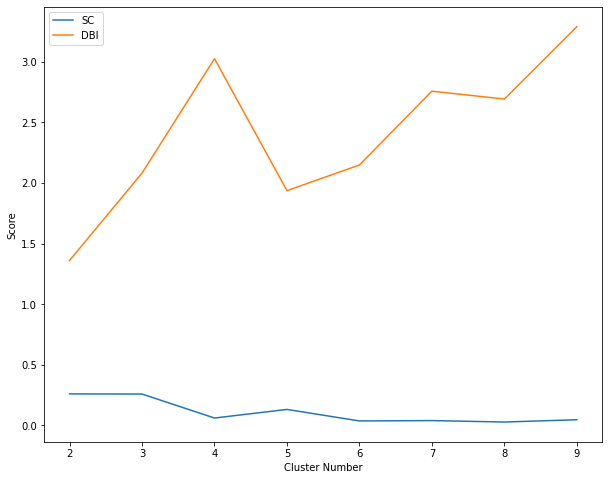

In [184]:
kmed_sil_list = []
kmed_db_index_list = []
for num in range(2, 10):
  kmed_labels, curr_medoids = kmed_cluster(dtw_distance, num)
  kmed_score = cluster_score(scaled_dtw, kmed_labels)
  kmed_sil_list.append(kmed_score[0])
  kmed_db_index_list.append(kmed_score[1])
  kmed_cluster_num = set(kmed_labels)
  print(f'Cluster={num}')
  print(f'Silhouette: {kmed_score[0]} and DB Index: {kmed_score[1]}')
plot_cluster_tuning(kmed_sil_list, kmed_db_index_list)